<a href="https://colab.research.google.com/github/sidvsukhi/Text-Summarization-of-T-C/blob/main/Project_ContractNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries and Loading Dataset

In [16]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [17]:
# Declaring constants
DATA_DIR = '/Users/siddhantsukhatankar/Desktop/Sid/NEU/ADS_DS5500/contract-nli'

In [18]:
# Opening JSON file
file_data = open(DATA_DIR + '/train.json')
data = json.load(file_data)

In [29]:
# Data consists of documents and labels
for key, value in data.items():
    print('Types of document: ', key,', Number of documents: ', len(value))

Types of document:  documents , Number of documents:  423
Types of document:  labels , Number of documents:  17


In [19]:
# Dataset main
main_df = pd.DataFrame(data['documents'])
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...",[{'annotations': {'nda-11': {'choice': 'NotMen...,search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [21]:
# Dataset labels
labels_df = pd.DataFrame(data['labels'])
labels_df.head()

,nda-11,nda-16,nda-15,nda-10,nda-2,nda-1,nda-19,nda-12,nda-20,nda-3,nda-18,nda-7,nda-17,nda-8,nda-13,nda-5,nda-4
short_description,No reverse engineering,Return of confidential information,No licensing,Confidentiality of Agreement,None-inclusion of non-technical information,Explicit identification,Survival of obligations,Permissible development of similar information,Permissible post-agreement possession,Inclusion of verbally conveyed information,No solicitation,Sharing with third-parties,Permissible copy,Notice on compelled disclosure,Permissible acquirement of similar information,Sharing with employees,Limited use
hypothesis,Receiving Party shall not reverse engineer any...,Receiving Party shall destroy or return some C...,Agreement shall not grant Receiving Party any ...,Receiving Party shall not disclose the fact th...,Confidential Information shall only include te...,All Confidential Information shall be expressl...,Some obligations of Agreement may survive term...,Receiving Party may independently develop info...,Receiving Party may retain some Confidential I...,Confidential Information may include verbally ...,Receiving Party shall not solicit some of Disc...,Receiving Party may share some Confidential In...,Receiving Party may create a copy of some Conf...,Receiving Party shall notify Disclosing Party ...,Receiving Party may acquire information simila...,Receiving Party may share some Confidential In...,Receiving Party shall not use any Confidential...


Cleaning Dataset
1. NULL values removal
2. Duplicate values removal

In [22]:
# Null values removal
main_df.isnull().sum()

id                 0
file_name          0
text               0
spans              0
annotation_sets    0
document_type      0
url                0
dtype: int64

In [23]:
# Duplicate documents removal
duplicate_exists = main_df['id'].duplicated()
duplicate_exists

0      False
1      False
2      False
3      False
4      False
       ...  
418    False
419    False
420    False
421    False
422    False
Name: id, Length: 423, dtype: bool

Adding/Updating important columns in dataset-
1. Annotations_sets - making it into a dictionary
2. New_Annotations - getting text to nda mapping

In [24]:
# Getting rid of nested annotations
main_df['annotation_sets'] = main_df['annotation_sets'].apply(lambda x: x[0]['annotations'])
main_df.head()

,id,file_name,text,spans,annotation_sets,document_type,url
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.ungm.org/UNUser/Documents/Download...
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.copernicus-masters.com/wp-content/u...
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.electricitysubsector.org/-/media/F...
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.databoiler.com/index_htm_files/DBT%...
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.astho.org/Programs/Infectious-Disea...


In [27]:
# Important function- Accessing text using spans and accessing spans using annotation sets
def get_text_to_nda_mapping(spans, annotation_sets, text):
    temp_di = {}
    for key, value in annotation_sets.items():
        annotation_span_new = []
        for annotation_span in value['spans']:
            annotation_span_new.append(text[spans[annotation_span][0]:spans[annotation_span][1]])
        temp_di[key] = {'choice': value['choice'], 'spans': annotation_span_new}
    return temp_di

In [28]:
main_df['annotations_new'] = main_df.apply(lambda x: get_text_to_nda_mapping(x.spans, x.annotation_sets, x.text), axis=1)
main_df

,id,file_name,text,spans,annotation_sets,document_type,url,annotations_new
0,34,Annex E_Non-Disclosure and Confidentiality Agr...,NON-DISCLOSURE AND CONFIDENTIALITY AGREEMENT\n...,"[[0, 44], [45, 132], [133, 331], [332, 417], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.ungm.org/UNUser/Documents/Download...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
1,86,CopAcc_NDA-and-ToP-Mentors_2.0_2017.pdf,NON-DISCLOSURE AGREEMENT AND TERMS OF PARTICIP...,"[[0, 51], [52, 68], [69, 222], [223, 358], [35...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.copernicus-masters.com/wp-content/u...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
2,87,Cyber Mutual Assistance NDA.pdf,Mutual Non-Disclosure and Use of Information A...,"[[0, 54], [55, 99], [100, 400], [401, 423], [4...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,https://www.electricitysubsector.org/-/media/F...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
3,88,DBT%20Mutual%20NDA.pdf,MUTUAL NON-DISCLOSURE AGREEMENT\nThis Non-Disc...,"[[0, 31], [32, 142], [142, 276], [277, 440], [...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.databoiler.com/index_htm_files/DBT%...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
4,89,Data Use Agreement New York City.pdf,Data Use And Non-Disclosure Agreement\nBetween...,"[[0, 28], [28, 37], [38, 45], [46, 103], [104,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",search-pdf,http://www.astho.org/Programs/Infectious-Disea...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
...,...,...,...,...,...,...,...,...
418,620,1592288_0001193125-17-306543_d469659dex99e2.htm,"Exhibit (e)(2)\nSeptember 19, 2017\nUltragenyx...","[[0, 8], [8, 14], [15, 33], [34, 64], [65, 82]...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",sec-html,https://www.sec.gov/Archives/edgar/data/000159...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
419,621,1609351_0001193125-19-066373_d642137dex99d2.htm,Exhibit 99.(d)(2)\nMUTUAL NON-DISCLOSURE AGREE...,"[[0, 11], [11, 17], [18, 49], [50, 468], [468,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",sec-html,https://www.sec.gov/Archives/edgar/data/000160...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
420,622,1628908_0001193125-15-169530_d838828dex1016.htm,"Exhibit 10.16\nAMENDED AND RESTATED\nSERVICES,...","[[0, 13], [14, 34], [35, 83], [84, 468], [469,...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",sec-html,https://www.sec.gov/Archives/edgar/data/000162...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."
421,623,1689602_0001144204-16-140940_v455386_ex10-3.htm,Exhibit 10.3\nNON-COMPETITION AGREEMENT\nWHERE...,"[[0, 12], [13, 38], [39, 549], [550, 785], [78...","{'nda-11': {'choice': 'NotMentioned', 'spans':...",sec-html,https://www.sec.gov/Archives/edgar/data/000168...,"{'nda-11': {'choice': 'NotMentioned', 'spans':..."


In [30]:
# Get respective counts of nda for each Document
def get_document_nda_counts():
    document_annotations = {}

    for document in data['documents']:
        temp_annotations = {}
        for key, value in document['annotation_sets'][0]['annotations'].items():
            temp_annotations[key] = len(value['spans'])
        document_annotations[document['id']] = temp_annotations

    return document_annotations

document_annotations = get_document_nda_counts()

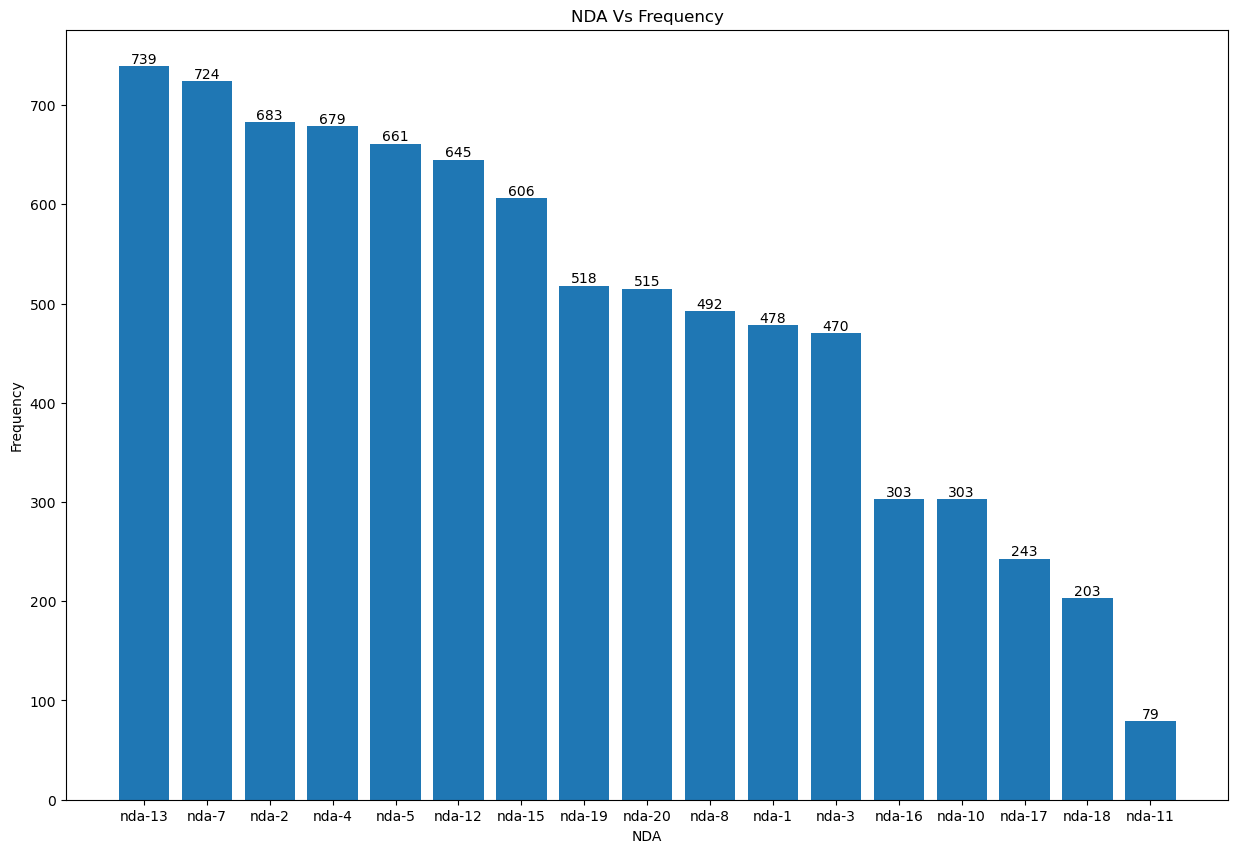

In [31]:
def get_total_nda_counts(document_annotations):
  nda_counts_dict = {}

  for key, value in document_annotations.items():
      for nda, nda_count in value.items():
          if nda not in nda_counts_dict:
              nda_counts_dict[nda] = nda_count
          else:
              nda_counts_dict[nda] += nda_count

  return nda_counts_dict


def plot_nda(nda_counts_dict):
  sorted_nda=dict(sorted(nda_counts_dict.items(), key=lambda item: item[1], reverse=True))
  plt.subplots(figsize=(15,10))
  plt.bar(range(len(sorted_nda)), list(sorted_nda.values()))
  plt.xticks(range(len(sorted_nda)), list(sorted_nda.keys()))
  plt.title("NDA Vs Frequency")
  plt.xlabel("NDA")
  plt.ylabel("Frequency")
  for i, v in enumerate(sorted_nda.values()):
        plt.text(i, v + 3, str(v), ha='center')
  plt.show()

nda_counts=get_total_nda_counts(document_annotations)
plot_nda(nda_counts)